# **I. Import dataset**

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1KHp3P5Z4VJBY8ekhxOmIwlVP2dwtB1f0/view?usp=sharing'
file_name = 'Home_Equity.csv'

downloaded = drive.CreateFile({'id':"1KHp3P5Z4VJBY8ekhxOmIwlVP2dwtB1f0"})   
downloaded.GetContentFile(file_name)

# **II. Understanding data**

[Nguồn Dữ Liệu](https://drive.google.com/file/d/1KHp3P5Z4VJBY8ekhxOmIwlVP2dwtB1f0/view?usp=sharing)

Tập dữ liệu chứa thông tin của các cho vay vốn sở hữu nhà

Ý nghĩa Chi Tiết Các Cột:

*   BAD: Cho biết tình trạng của người nộp đơn 
    •	1: KH bị vỡ nợ
    •	0: Khoản nợ đã được hoàn trả 
*   LOAN: Số tiền yêu cầu vay
*   MORTDUE: Số tiền khách hàng thế chấp.
*   VALUE: Giá trị của tài sản khách hàng.
*   Reason : Lý do:
    •	DebtCon = debt consolidation
    •	HomeImp = Home Improvement
*   JOB: công việc.
*   YOJ: Số năm làm của công việc hiện tại
*   DEROG: Số lượng báo cáo vi phạm chính
*   DELINQ: Số hạn mức tín dụng quá hạn
*   CLAGE:	Clage	Thời điểm của giao dịch cũ nhất trong tháng	
*   NINQ: Số hạn mức tín dụng gần đây
*   CLNO: Số lượng hạn mức tín dụng
*   DEBTINC: Tỷ lệ nợ trên thu nhập



**Yêu Cầu Phân Tích:** tự động hóa quy trình ra quyết định để phê duyệt các hạn
mức tín dụng vốn góp mua nhà

# **III. Exploring data**

## 1/ Exploring null and duplicate data

In [ ]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime,time
import pandas as pd

df=pd.read_csv(file_name)

#Nhìn khái quát những dòng đầu tiên của tập dữ liệu
print('Số cột của tập dữ liệu:', df.shape[1])
print('Số dòng của tập dữ liệu:',df.shape[0])
df.head(10)



Số cột của tập dữ liệu: 13
Số dòng của tập dữ liệu: 5960


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
6,1,1800,48649.0,57037.0,HomeImp,Other,5.0,3.0,2.0,77.100000,1.0,17.0,NaN
7,1,1800,28502.0,43034.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
8,1,2000,32700.0,46740.0,HomeImp,Other,3.0,0.0,2.0,216.933333,1.0,12.0,NaN
9,1,2000,NaN,62250.0,HomeImp,Sales,16.0,0.0,0.0,115.800000,0.0,13.0,NaN


**Nhận Xét:** 
 
*  Có thể thấy đối với cột BAD dữ liệu chỉ bao gồm 2 giá trị là 0 và 1. Đây là cột dùng để dự đoán 
*   Đối với cột DEBTINC, dữ liệu bị mất tương đối nhiều
*   Ở dòng 3 của tập dữ liệu, dữ liệu trong dòng đó bị mất tương đối nhiều
*   Đối với cột Reason, ta thấy giá trị "HomeImp" xuất hiện với tần suất lớn
*   Với cột Job, ta cũng thấy giá trị "Other" cũng xuất hiện với tần suất lớn









In [ ]:
# Thống kê dữ liệu null
print('Phần trăm dữ liệu null ở mỗi cột:\n')
round((df.isnull().sum()*100)/5960,2) 

Phần trăm dữ liệu null ở mỗi cột:



BAD         0.00
LOAN        0.00
MORTDUE     8.69
VALUE       1.88
REASON      4.23
JOB         4.68
YOJ         8.64
DEROG      11.88
DELINQ      9.73
CLAGE       5.17
NINQ        8.56
CLNO        3.72
DEBTINC    21.26
dtype: float64


**Nhận xét:**
*   Dựa vào thống kê ở trên ta nhận thấy rằng cột DEBTINC bị mất dữ liệu nhiều, chiếm 21,26%
*   Bên cạnh đó các cột như DEROG, YOJ, DELINQ, NINQ cũng bị khuyết dữ liệu ở một ngưỡng tương đối
*   Đối với các cột còn lại thì dữ liệu bị khuyết tương đối ít, không đáng kể







In [ ]:
#Thống kê trùng lắp dữ liệu
df.duplicated().sum()

0


**Nhận xét:**
*   Không có dữ liệu trung lắp




## 2/ Exploring distribution of data

In [ ]:
#Tìm min, max, std của các cột và nhận xét
df.describe()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


**Đối với cột BAD**
  #Như đã đề cập dữ liệu trong cột chỉ tồn tại gồm 2 giá trị là 0 và 1
  #Dựa trên bảng thống kê ở phía trên, ta có thể thấy tới 75% giá trị của tập dữ liệu đều nhỏ hơn 0 
  #Điều đó có thể cho ta thấy giá trị 0 chiếm tỉ trọng cao tập dữ liệu. 


---



**Đối với cột LOAN**
  #Ta thấy nhận thấy có sự chênh lệch rất lớn giữa giá trị lớn nhất và giá trị nhỏ nhất (1100 << 89900). 
  #Với độ lệch chuẩn nhỏ ta dự đoán dữ liệu sẽ không phân tán quá rộng  
  #Cùng với đó Với giá trị trung bình là 18607 và 50% dữ liệu đều nhỏ hơn 16300 
  #ta có thể nhận xét rằng dữ liệu sẽ tập trung đông xung quanh giá trị trung bình


---


**Đối với cột MORTDUE**
  #Ta cũng nhận thấy có sự chênh lệch lớn giữa giá trị lớn nhất và giá trị nhỏ nhất (1100 << 89900)
  #Giá trị trung bình của cột là 73760 và độ lệch chuẩn không quá lớn 
  #ta dự đoán dữ liệu sẽ phân tán không quá rộng và tập trung xung quanh giá trị trung bình


---


**Đối với cột YOJ **
  #Tượng trưng cho số năm làm việc công việc hiện tại của KH
  #Số năm làm việc dao động trong khoảng từ 0 - 41
  #Số năm làm việc trung bình khoảng 9 năm và với độ lệch chuẩn lớn nên dữ liệu sẽ phân tán rộng


---

**#Đối với cột DEBTINC (Debt to income)**
  #Cột thể hiện tỉ lệ nợ chiếm tỉ trọng như thế nào so với thu nhập hiện tại của KH
  #Tỉ lệ dao động trong khoảng từ 0.52% - 203.31% và với giá trị trung bình là 33,78%
  #Với độ lệch chuẩn là 8,6% < giá trị trung bình nên có thể nói dữ liệu phân bố không đều

### a.Bad

BAD
0    4771
1    1189
Name: BAD, dtype: int64 



Text(0.5, 1.0, 'Percentage of BAD')

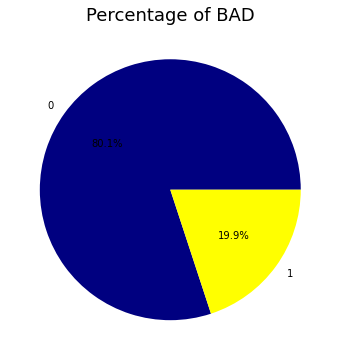

In [ ]:
print(df.groupby('BAD').BAD.count(),'\n')

x, y = np.unique(df['BAD'], return_counts = True)
plt.figure(figsize=(16, 6))
plt.pie(y,
        labels = x, # Nhãn của các nhóm
        colors = ['Navy', 'yellow'], # Màu sắc của các nhóm
        autopct = '%1.1f%%', # Format hiển thị giá trị %
        shadow = False)
plt.title("Percentage of BAD", fontsize=18)

**Nhận xét:**

*   Có thể thấy tỉ lệ KH trả được khoản vay chiếm tỉ trọng lớn hơn gấp 4 lần so với tỉ lệ không trả được nợ(80.1 % và 19.9%)





### b.Loan 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


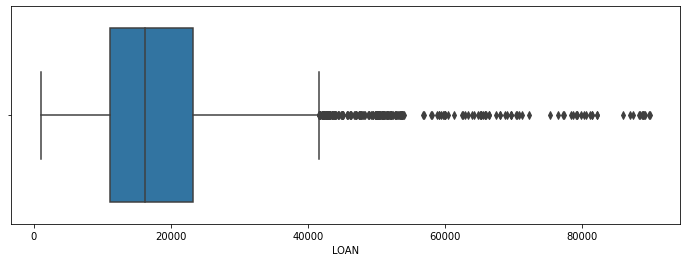

In [ ]:
#Biểu đồ BoxPlot
plt.figure(figsize=(12,4))
sns.boxplot(df['LOAN'])


**Nhận xét:**
*   Các Outlier xuất hiện rất nhiều ở cột này (LOAN), nhưng vì nó mang ý nghĩa tiền bạc ==> KHÔNG CÓ GI BẤT THƯỜNG
*  Dữ liệu phân phối KHÔNG ĐỀU,  có xu hướng lệch phải


Text(0.5, 1.0, 'Histogram of LOAN')

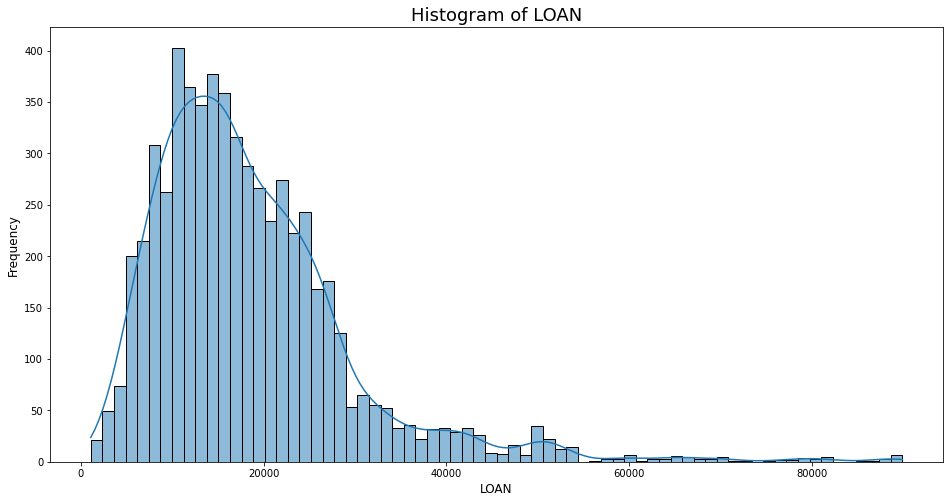

In [ ]:
#Biểu đồ Histogram
plt.figure(figsize=(16, 8))
sns.histplot(x='LOAN', data = df, bins=70, kde = True)
plt.xlabel('LOAN', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Histogram of LOAN", fontsize=18)



*   Dữ liệu ở đây phân phối không đều và bị lệch về phía bên trái. 
* Số tiền mà các KH muốn vay chiếm phần lớn từ 10000 - 30000$ và cao nhất ở 89900


 c.Mortdue 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


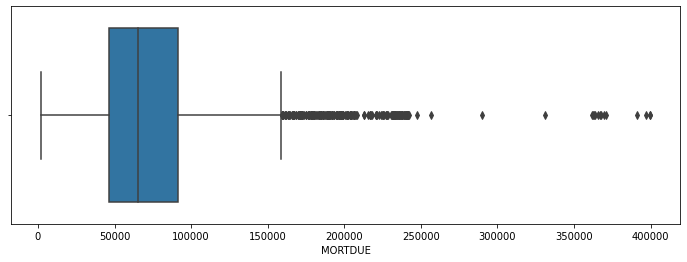

In [ ]:
#Biểu đồ BoxPlot
plt.figure(figsize=(12,4))
sns.boxplot(df['MORTDUE'])

**Nhận xét:**
*   Các Outlier xuất hiện rất nhiều ở cột này (MORTDUE), nhưng vì nó mang ý nghĩa tiền bạc ==> KHÔNG CÓ GI BẤT THƯỜNG
*  Dữ liệu phân phối KHÔNG ĐỀU,  có xu hướng lệch phải 

Text(0.5, 1.0, 'Histogram of MORTDUE')

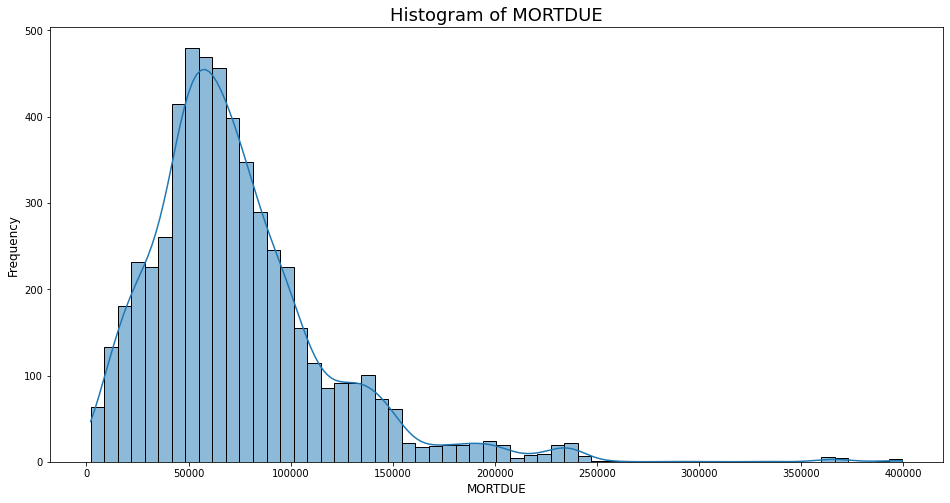

In [ ]:
#Biểu đồ Histogram
plt.figure(figsize=(16, 8))
sns.histplot(x='MORTDUE', data = df, bins=60, kde = True)
plt.xlabel('MORTDUE', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Histogram of MORTDUE", fontsize=18)



*   Ta có thể thấy dữ liệu phân bố không đồng đều và bị lệch nhiều về phía bên trái.
*   Bên cạnh đó, ở biểu đồ histogram ta thấy có giá trị từ 25000 – 40000 xuất hiện riêng lẻ 
nên rất có khả năng những giá trị này là những outlier của tập dữ liệu 

 


###d. Debtinc

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


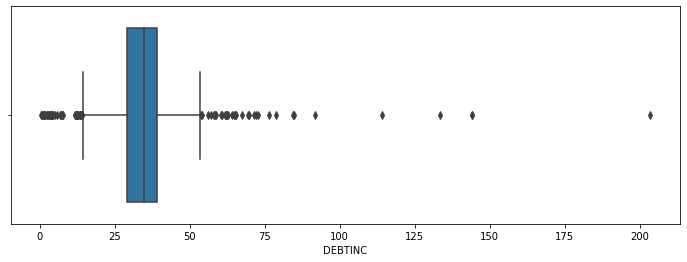

In [ ]:
#Biểu đồ BoxPlot
plt.figure(figsize=(12,4))
sns.boxplot(df['DEBTINC'])




*   Có Outlier xuất hiện khá nhiều ở cột DEBTINC 






Text(0.5, 1.0, 'Histogram of DEBTINC')

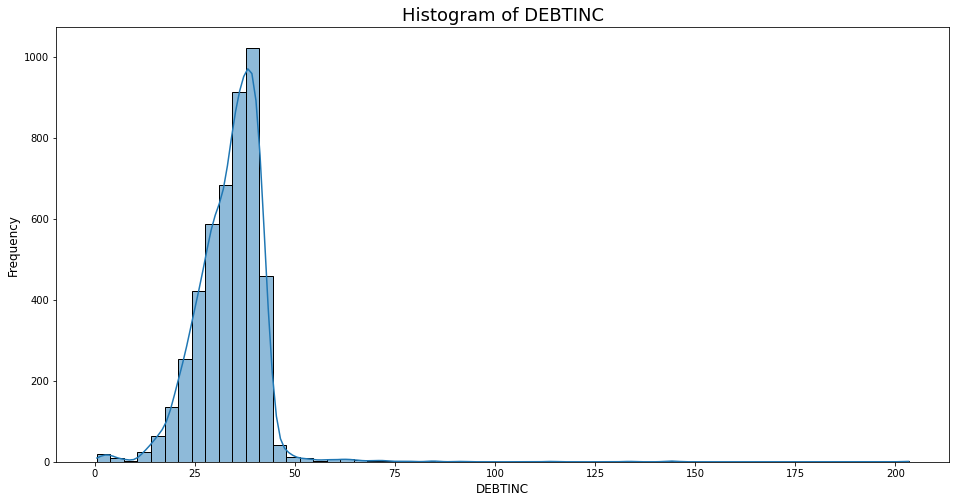

In [ ]:
#Biểu đồ Histogram
plt.figure(figsize=(16, 8))
sns.histplot(x='DEBTINC', data = df, bins=60, kde = True)
plt.xlabel('DEBTINC', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Histogram of DEBTINC", fontsize=18)



*   Biểu đồ phân bố không đồng đều tập trung chủ yếu từ 25% đến 45%.
*   Khoảng % tỉ lệ nợ trên thu nhập phân bố trải dài từ 0 đến 200%
*   Nhìn vào biểu đồ ta có thể thấy tỉ lệ nợ trên thu nhập ở khoảng 100-200% vẫn có xuất hiện.






###e. Job

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64 



Text(0.5, 1.0, 'Percentage of Job')

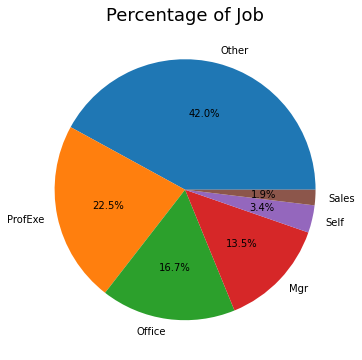

In [ ]:
#Biểu đồ tỉ trọng Job column
job = df['JOB'].value_counts()
print(job,'\n')

plt.figure(figsize=(16, 6))
plt.pie(job,
        labels = job.index, # Nhãn của các nhóm
        autopct = '%1.1f%%', # Format hiển thị giá trị %
        shadow = False)
plt.title("Percentage of Job", fontsize=18)



*   Ở Job column, dữ liệu được phân thành 6 nhóm ngành nghề là ProfExe, Office, Mgr, Self, Sales, Other.
*   Sales và Other chiếm tỉ lệ chênh lệch nhau khá nhiều (1.9% và 42% )
*   Trong đó nhóm Other chiếm tỉ trọng cao nhất (42%) và nhóm ngành Sales chiếm tỉ trọng thấp nhất (1.9%)









### f. Value

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


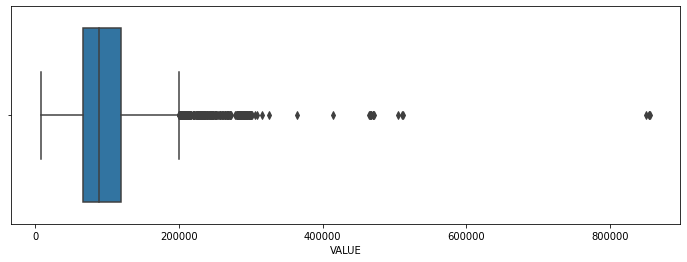

In [ ]:
#Biểu đồ BoxPlot
plt.figure(figsize=(12,4))
sns.boxplot(df['VALUE'])


**Nhận xét:**
*   Các Outlier xuất hiện rất nhiều ở cột này (VALUE), nhưng vì nó mang ý nghĩa tiền bạc ==> KHÔNG CÓ GI BẤT THƯỜNG
*  Dữ liệu phân phối KHÔNG ĐỀU,  có xu hướng lệch phải


Text(0.5, 1.0, 'Histogram of VALUE')

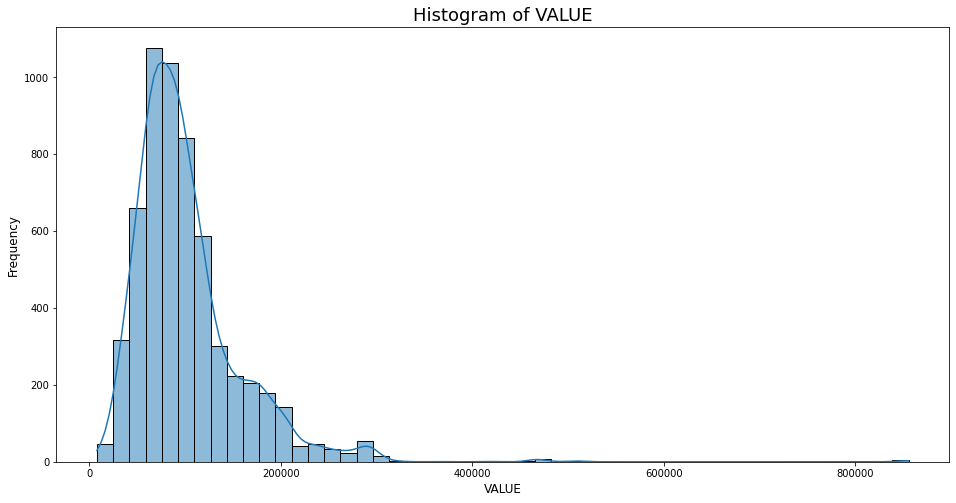

In [ ]:
#Biểu đồ Histogram
plt.figure(figsize=(16, 8))
sns.histplot(x='VALUE', data = df, bins=50, kde = True)
plt.xlabel('VALUE', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Histogram of VALUE", fontsize=18)


*   Biểu đồ phân bố giá trị không đông đều trải dài từ 0 đến ngoài 800000.

*   Nhìn vào biểu đồ Histogram giá trị tài sản tập trung chủ yếu  từ 50000 đến 2000000





###g. Mortdue

In [ ]:
#Mô tả Mortdue
df['MORTDUE'].describe()
#Đối với cột MORTDUE
  #Ta cũng nhận thấy có sự chênh lệch lớn giữa giá trị lớn nhất và giá trị nhỏ nhất (2063 << 399550)
  #Giá trị trung bình của cột là 74075 và độ lệch chuẩn 42242 không quá lớn 
  #ta dự đoán dữ liệu sẽ phân tán không quá rộng và tập trung xung quanh giá trị trung bình

count      5713.000000
mean      74075.817024
std       42242.407143
min        2063.000000
25%       48437.000000
50%       69320.000000
75%       88829.000000
max      399550.000000
Name: MORTDUE, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


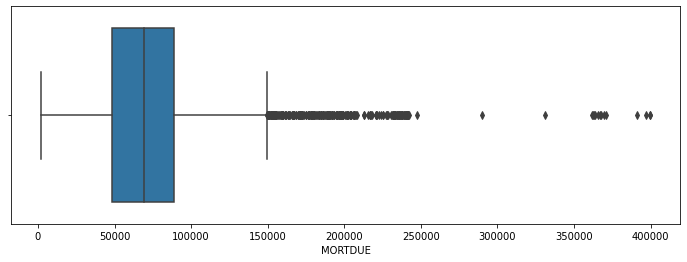

In [ ]:
#Biểu đồ BoxPlot

plt.figure(figsize=(12,4))
sns.boxplot(df['MORTDUE'])




*   Ta thấy biểu đồ có xu hướng lệch phải
*   Các giá trị ngoài giá trị 150000(outliers) xuất hiện nhiều







Text(0.5, 1.0, 'Histogram of MORTDUE')

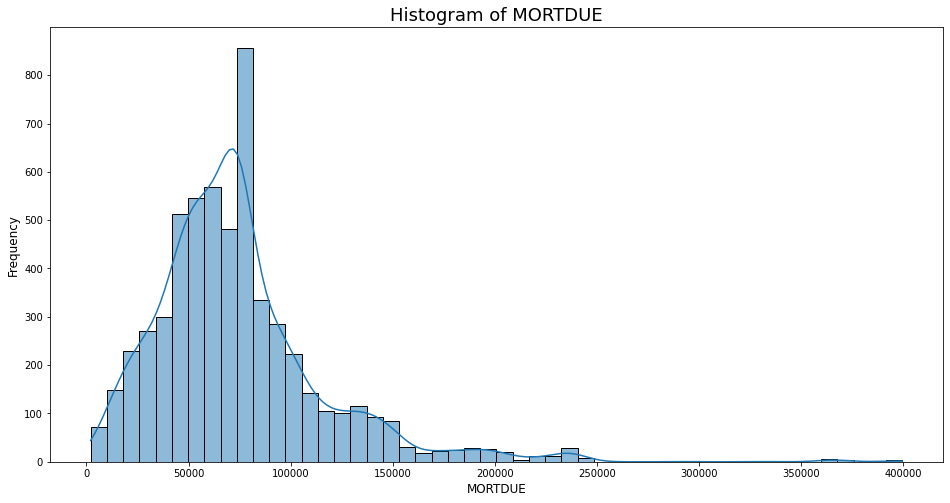

In [ ]:
#Biểu đồ Histogram
plt.figure(figsize=(16, 8))
sns.histplot(x='MORTDUE', data = df, bins=50, kde = True)
plt.xlabel('MORTDUE', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title("Histogram of MORTDUE", fontsize=18)



*    Biểu đồ phân bố không đồng đều, các giá trị trải dài 0-400000
*    Các giá trị tập trung xung quanh giá trị mean (74075)
*    Các giá trị tập trung chủ yếu từ khoảng 25000 đến 100000





##3/ Exploring correlation

##Overview

In [ ]:
df=pd.get_dummies(df,columns=['REASON','JOB'],drop_first=True)# chuyển đổi các dư liệu dạng category về dạng numeric

In [ ]:

df=df.rename(columns={'BAD':'Target'})## đổi tên cột BAD thành Target
cols = list(df.columns.values)
cols.pop(cols.index('Target'))
df = df[cols+['Target']] # chuyển cột Target về cuối 

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,Target
LOAN,1.000000,0.224497,0.339603,0.106731,0.010345,-0.033976,0.084340,0.043126,0.073053,0.103376,-0.160589,-0.025337,-0.052388,0.011063,-0.046264,0.170913,-0.083566
MORTDUE,0.224497,1.000000,0.780030,-0.086571,-0.049655,-0.005774,0.150075,0.022950,0.302703,0.143808,-0.009958,-0.057323,-0.259963,0.249216,0.023531,0.109582,-0.053121
VALUE,0.339603,0.780030,1.000000,0.001176,-0.043451,-0.005693,0.182631,-0.008693,0.258361,0.135754,0.005814,-0.051955,-0.263569,0.260924,0.014951,0.144414,-0.031244
YOJ,0.106731,-0.086571,0.001176,1.000000,-0.055805,0.042634,0.194788,-0.072740,0.018157,-0.074887,0.042810,-0.041396,0.055418,-0.012604,-0.036185,-0.053099,-0.058792
DEROG,0.010345,-0.049655,-0.043451,-0.055805,1.000000,0.173137,-0.084926,0.141666,0.040773,-0.012501,-0.011913,-0.046934,0.036806,-0.036954,0.032533,-0.000323,0.269502
DELINQ,-0.033976,-0.005774,-0.005693,0.042634,0.173137,1.000000,0.024910,0.049207,0.158036,0.018413,0.004583,0.012504,-0.047790,-0.005328,-0.016404,0.019794,0.344161
CLAGE,0.084340,0.150075,0.182631,0.194788,-0.084926,0.024910,1.000000,-0.110134,0.234204,0.000735,0.039911,-0.014339,-0.072921,0.104481,0.030602,0.005885,-0.163888
NINQ,0.043126,0.022950,-0.008693,-0.072740,0.141666,0.049207,-0.110134,1.000000,0.079701,0.128875,-0.118063,-0.059197,0.057382,-0.064262,-0.036929,0.016591,0.160689
CLNO,0.073053,0.302703,0.258361,0.018157,0.040773,0.158036,0.234204,0.079701,1.000000,0.151443,-0.099290,-0.008663,-0.190313,0.158463,0.048116,0.039899,-0.015999
DEBTINC,0.103376,0.143808,0.135754,-0.074887,-0.012501,0.018413,0.000735,0.128875,0.151443,1.000000,-0.037765,0.079184,0.000722,-0.112477,0.015039,-0.008097,0.050306


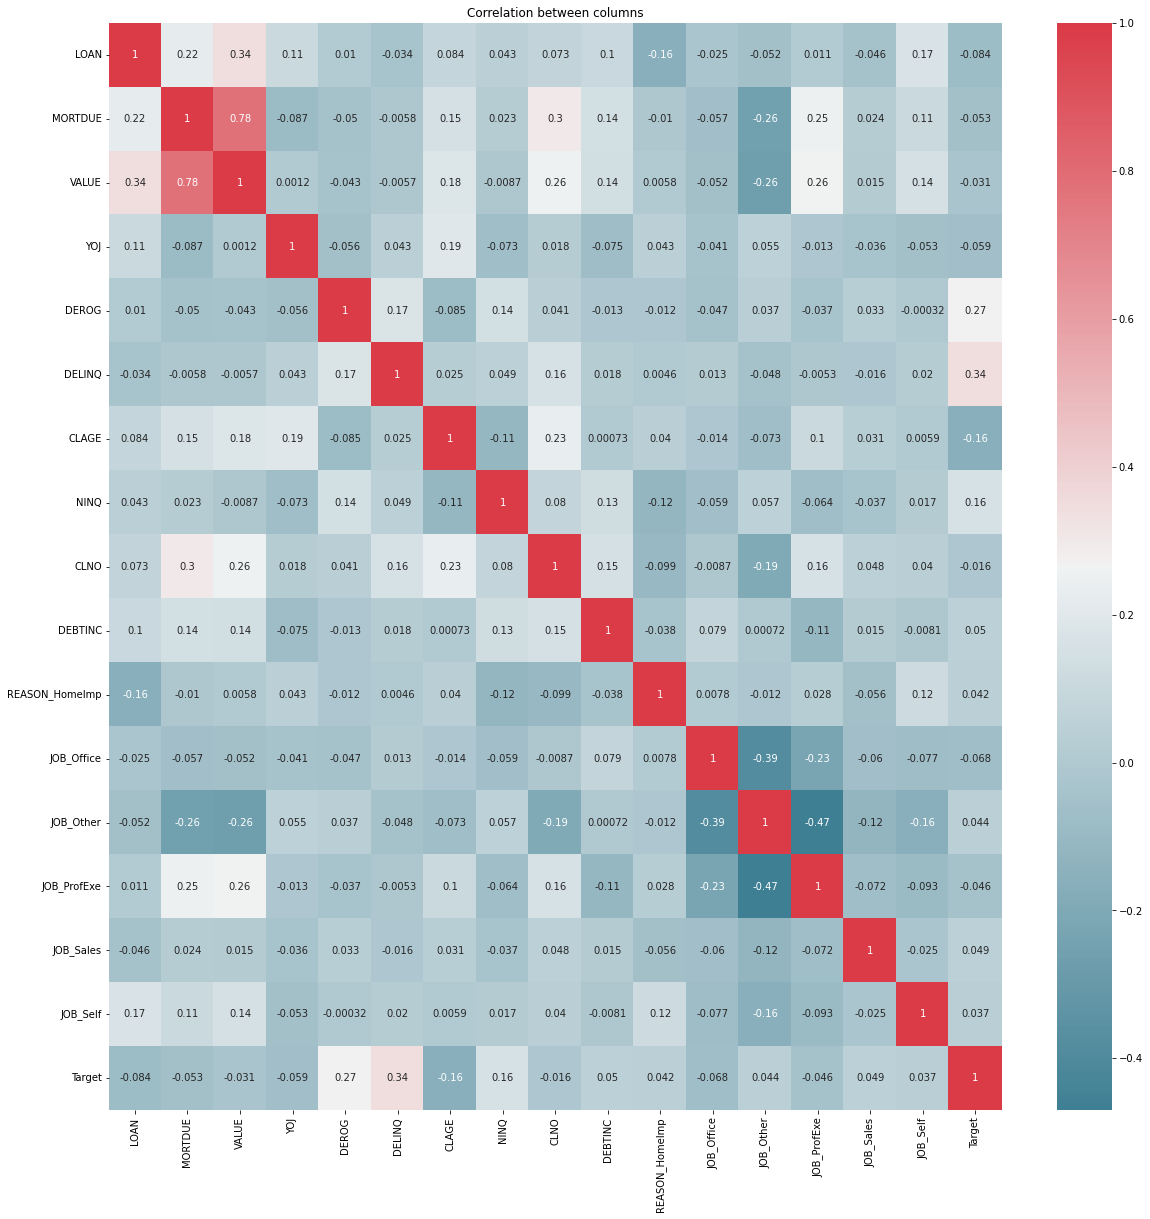

In [ ]:

colormap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(20,20))
heat_map = sns.heatmap(df.corr(),cmap = colormap,annot=True)
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
# sns.color_palette("mako", as_cmap=True)
plt.title('Correlation between columns')
df.corr()

**Nhận xét:** 
*   Dễ dàng nhận thấy rằng giữa cột MORTUE và VALUE có một mối tương quan khá mạnh lên tới 0.78.
*   Đối với các cột còn lại ta nhận thấy rằng mối tương quan giữa chúng tương đối kém






##Finding regression expression between columns

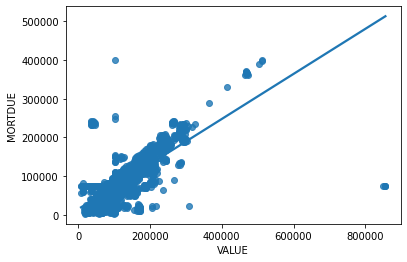

In [ ]:
# Biểu đồ thể hiện mối quan hệ trên đường hồi quy tuyến tính của MORTDUE và VALUE
sns.regplot(y = "MORTDUE",x='VALUE', ci= None, data = df)


#III. Cleansing data

In [ ]:
#Show ra những điểm dữ liệu missing ở phần lớn các cột
# Ta thấy có 9 dòng có phần lớn dữ liệu ở các cột là NULL, nên ta sẽ DROP 9 dòng này

nan_many = df[df['MORTDUE'].isna() & df['VALUE'].isna() & df['REASON'].isna() & df['JOB'].isna()]
print(nan_many.shape)
nan_many


(9, 13)


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1405,0,10800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1507,0,11100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.232459
1897,0,12500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.352644
1959,0,12800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.132449
1960,0,12800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.659670
2303,0,14000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.689711
2449,0,14700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.595378
2635,1,15100,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN


### Xử lý các dòng có phần lớn dữ liệu là NULL

In [ ]:
#Xóa bỏ các điểm dữ liệu trên
df.drop(index=nan_many.index, inplace = True)
df = df.reset_index(drop=True)
df[df['MORTDUE'].isna() & df['VALUE'].isna() & df['REASON'].isna() & df['JOB'].isna()]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC


###REASON và JOB

In [ ]:
# Ở 2 trường hợp kiểu dữ liệu là Object ( REASON và JOB )
# (Thay thế cho giá trị có FREQ xuất hiện nhiều nhất): 

print(df[['REASON', 'JOB']].describe())

         REASON    JOB
count      5708   5681
unique        2      6
top     DebtCon  Other
freq       3928   2388


In [ ]:
#Reason thì thay thế các giá trị NaN bằng DebtCon
#Job  thì thay thế các giá trị NaN bằng Other

df["REASON"].fillna(value = "DebtCon",inplace = True)
df["JOB"].fillna(value = "Other",inplace = True)

###DEROG và DELINQ

In [ ]:
# Trong trường hợp các cột DEROG và DELINQ, giá trị 0 xuất hiện nhiều nhất

derog = df['DEROG'].value_counts()
print(derog)
delinq = df['DELINQ'].value_counts()
print(delinq)


0.0     4526
1.0      435
2.0      160
3.0       58
4.0       23
6.0       15
5.0       15
7.0        8
8.0        6
9.0        3
10.0       2
Name: DEROG, dtype: int64
0.0     4178
1.0      654
2.0      250
3.0      129
4.0       78
5.0       38
6.0       27
7.0       13
8.0        5
11.0       2
10.0       2
13.0       1
12.0       1
15.0       1
Name: DELINQ, dtype: int64


In [ ]:
# thay thế các giá trị NaN ở 2 cột DEROG và DELINQ bằng giá trị 0
df["DEROG"].fillna(value=0,inplace=True)
df["DELINQ"].fillna(value=0,inplace=True)

### Các cột còn lại trong dataset

In [ ]:
# Các cột còn lại sẽ thay thế bằng giá trị trung bình mean
df.fillna(value=df.mean(),inplace=True)

#IV. Remove Outliers

## **Xác định outliners bằng IQR**

IQR là sự khác biệt giữa tứ phân vị thứ nhất Q1 và tứ phân vị thứ ba Q3:

IQR=Q3−Q1

Giá trị IQR có thể sử dụng để xác định outliers bằng cách thiết lập các giá trị biên Upper/Lower giống với phương pháp STD như sau: Nếu chúng ta trừ đi kxIQR từ tứ phân vị đầu tiên Q1, bất kỳ giá trị dữ liệu nào nhỏ hơn con số này được coi là giá trị outliers. Tương tự như vậy, nếu chúng ta thêm kxIQR đến tứ phân vị thứ ba Q3, bất kỳ giá trị dữ liệu nào lớn hơn con số này được coi là outliers. Giá trị k thường được chọn là 1.5. Trong trường hợp xác định các extreme outliers có thể dùng giá trị k = 3.

Các bước xác định outliers bằng phương pháp IQR:


*   Bước 1: Tính IQR
*   Bước 2: Tính giá trị biên Upper/Lower để xác định outliers
*   Bước 3: Xác định và loại bỏ outliers dựa trên giá trị biên






##DEBTINC

In [ ]:
#Tính IQR
q25, q75 = np.percentile(df["DEBTINC"], 25), np.percentile(df["DEBTINC"], 75)
iqr = q75 - q25
# Tính giá trị biên Upper/Lower để xác định outliers
limit_iqr = 1.5*iqr
lower_iqr, upper_iqr = q25 - limit_iqr, q75 + limit_iqr
#remove outliers
df.drop(df[df['DEBTINC'] < lower_iqr].index,inplace = True)
df.drop(df[df['DEBTINC'] > upper_iqr].index,inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


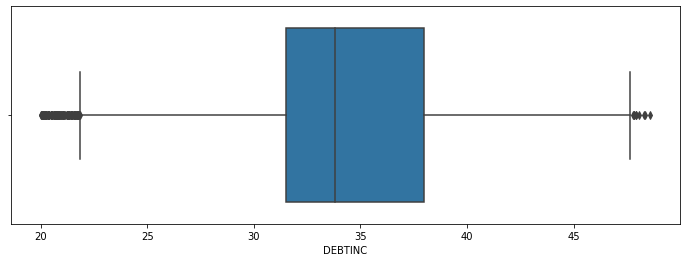

In [ ]:
#Biểu đồ BoxPlot DEBTINC sau khi remove outlier
plt.figure(figsize=(12,4))
sns.boxplot(df['DEBTINC'])

#V. Classification

Dựa vào cột BAD ta có thể tạm thời gán nhãn như sau:
1: KH bị vỡ nợ
2: KH đã hoàn trả 
Ta 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score

In [ ]:
random_seed = 888

# dividing df_train and df_test into train and test data
df_train, df_test = train_test_split(df, test_size= 0.2, random_state = random_seed, stratify = df['Target'])

print(df_train.shape)#dòng và cột trên tập train
print(df_test.shape)#dòng và cột trên tập test

(4562, 17)
(1141, 17)


In [ ]:
numeric_cols = ['LOAN', 'MORTDUE', 'VALUE','DEBTINC','YOJ',	'DEROG',	'DELINQ'	,'CLAGE',	'NINQ'	,'CLNO']
cat_cols = list(set(df.columns) - set(numeric_cols)-{'Target'})# chỉ lấy các cột có giá trị category
cat_cols.sort()

scaler = StandardScaler()
scaler.fit(df_train[numeric_cols])

def get_feature_and_target_arrays(df, numeric_cols, cat_cols, scaler):
  X_numeric_scaled = scaler.transform(df[numeric_cols])
  X_categorical = df[cat_cols].to_numpy()
  X = np.hstack((X_categorical, X_numeric_scaled))
  y = df['Target']
  return X, y

X, y = get_feature_and_target_arrays(df_train, numeric_cols, cat_cols,scaler)

In [ ]:
#Build Model
clf = LogisticRegression(penalty='none')
clf.fit(X,y)

LogisticRegression(penalty='none')

Test lại với tập test

In [ ]:
X_test, y_test = get_feature_and_target_arrays(df_test, numeric_cols, cat_cols,scaler)

Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


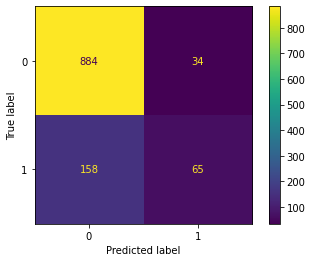

In [ ]:
# creating a confusion matrix
print('Confusion Matrix')
plot_confusion_matrix(clf, X_test, y_test)

In [ ]:
test_pred = clf.predict(X_test)
print ('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print ('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print ('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print ('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Accuracy = 0.83173
Precision = 0.65657
Recall = 0.29148
F1 score = 0.40373

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       918
           1       0.66      0.29      0.40       223

    accuracy                           0.83      1141
   macro avg       0.75      0.63      0.65      1141
weighted avg       0.81      0.83      0.80      1141



Độ chính xác của mô hình trên tập test là 83%

Dựa vào biểu đồ trên ta nhận thấy được rằng tỉ lệ nhận diện đúng của từng nhãn như sau:

0: 85%
1: 66%
Bên cạnh đó chúng ta còn nhận thấy được phần trăm giá trị bị bỏ sót như sau:

0:96%
1:29%